In [1]:
### Random Seed
from numpy.random import seed
seed(1)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
import csv

In [3]:
df = pd.read_csv('belt_sensor_all.csv')
print(df.shape)
df.head(2)

(108170, 22)


,Unnamed: 0,Pid,timestamp,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,...,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label
0,0,P1_BS,3.00,-84.23,-994.63,8.06,-0.37,-2.62,1.65,311.28,...,2.08,-3.23,-4.33,-68.12,-970.46,150.15,1.83,0.24,0.61,Downstairs
1,1,P1_BS,3.01,-86.43,-1004.15,16.85,-0.18,-3.17,0.85,301.76,...,6.77,3.05,-3.78,-73.24,-978.52,140.62,0.55,-0.24,0.31,Downstairs


In [4]:
df.groupby('Pid').size()

Pid
P1_BS            12278
P2_BS            13016
P3_BS            13016
P4_BS            12946
P5_BS            13016
p10_all_BS123     8825
p11_all_BS123     8598
p6_all_BS123      8825
p7_all_BS123      8825
p8_all_BS123      8825
dtype: int64

<h1>Denosing Filter</h1>

In [5]:
### Low Pass filter 
from scipy import signal
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [6]:
#low pass filter
lowpass_filtred=[]
dfm=df[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
for column in dfm.columns:# iterate over each column in raw_df
    cutoff_frequency = 15.0
    sample_rate=100
    t_signal=np.array(dfm[column]) #copie the signal values in 1D numpy array
    y = butter_lowpass_filter(t_signal,cutoff_frequency,sample_rate/2) 
    lowpass_filtred.append(y)
lowpass=pd.DataFrame(lowpass_filtred)
lowpass=lowpass.T
lowpass.columns=['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']
df1=df[['Pid','timestamp']]
df_filtred=pd.concat([df1,lowpass],axis=1)
df_filtred['Label']=df['Label']

In [7]:
df_filtred['Label'].value_counts()

Upstairs      29345
Downstairs    25030
Walking       19440
Standing      12180
Sitting       11265
Laying        10910
Name: Label, dtype: int64

<h1>CLASS BALANCE GRAPH</h1>

Class Counts:
 Upstairs      29345
Downstairs    25030
Walking       19440
Standing      12180
Sitting       11265
Laying        10910
Name: Label, dtype: int64


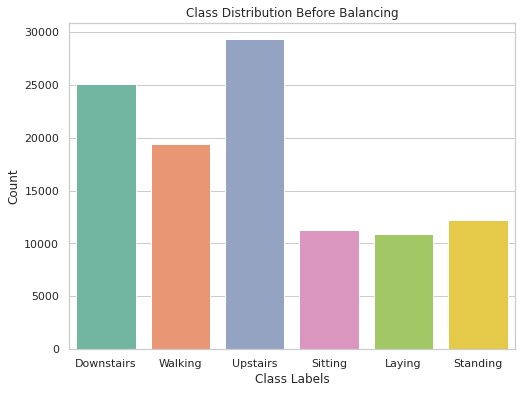

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Checking class balance
class_counts = df_filtred['Label'].value_counts()
print("Class Counts:\n", class_counts)

# Plotting class balance
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.countplot(x='Label', data=df_filtred, palette="Set2")
plt.title('Class Distribution Before Balancing')
plt.xlabel('Class Labels')
plt.ylabel('Count')

# # Displaying percentages on top of the bars
# total = len(df_filtred['Label'])
# for i, count in enumerate(class_counts):
#     plt.text(i, count + 0.1, f'{count/total*100:.2f}%', ha='center')

# Save the plot to a file if needed
# plt.savefig('class_balance_plot.png')

# Show the plot
plt.show()


<h1>SMOTE DATA OVER SAMPLING</h1>

In [9]:
from imblearn.over_sampling import SMOTE
# split data into input and output elements
X = df_filtred[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy',
       'S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
y = df_filtred[['Label']]

oversample = SMOTE()
Xo, yo = oversample.fit_resample(X, y)

df_Smoted=pd.concat([Xo,yo],axis=1)
print(df_Smoted.shape)
df_Smoted.head(2)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x15039ea77ca0>
Traceback (most recent call last):
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/cluster/apps/eb/software/Anaconda3/2022.05/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback

(176070, 19)


,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,S2_Ay,S2_Az,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label
0,-84.222490,-994.627346,8.055153,-0.370396,-2.620791,1.649596,311.291489,-1061.332673,81.294603,2.077435,-3.234044,-4.329407,-68.121248,-970.461276,150.138268,1.829730,0.240081,0.610366,Downstairs
1,-88.069874,-998.773910,11.651440,-0.282880,-3.161370,0.810362,301.127326,-1027.592784,86.576920,6.452058,2.962058,-3.769370,-70.387323,-977.643665,146.687971,0.477777,-0.317638,0.282808,Downstairs


<h2>LABEL ENCODING</h2>

In [10]:
df_Smoted['Label_id']=df_Smoted['Label']
dff=df_Smoted.replace({'Label_id': {'Downstairs':0,'Walking':1,'Upstairs':2,
                        'Sitting':3,'Laying':4,'Standing':5}})
dff.head(2)

,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,S2_Ay,S2_Az,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label,Label_id
0,-84.222490,-994.627346,8.055153,-0.370396,-2.620791,1.649596,311.291489,-1061.332673,81.294603,2.077435,-3.234044,-4.329407,-68.121248,-970.461276,150.138268,1.829730,0.240081,0.610366,Downstairs,0
1,-88.069874,-998.773910,11.651440,-0.282880,-3.161370,0.810362,301.127326,-1027.592784,86.576920,6.452058,2.962058,-3.769370,-70.387323,-977.643665,146.687971,0.477777,-0.317638,0.282808,Downstairs,0


<h2>NORMAILIZATION</h2>

In [11]:
# Label encoding
df_filtred['Label_id']=df_filtred['Label']
dff=df_filtred.replace({'Label_id': {'Downstairs':0,'Walking':1,'Upstairs':2,
                        'Sitting':3,'Laying':4,'Standing':5}})
## Normalize/Standardize data
from sklearn.preprocessing import StandardScaler, LabelEncoder
X = dff[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
       'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']]
y = dff['Label_id']
scaler = StandardScaler()
dx = scaler.fit_transform(X)

df_scaled = pd.DataFrame(data = dx, columns = X.columns)
df_scaled['Label_id'] = y.values

print(df_scaled.shape)
df_scaled.tail(2)

(108170, 19)


,S1_Ax,S1_Ay,S1_Az,S1_Gx,S1_Gy,S1_Gz,S2_Ax,S2_Ay,S2_Az,S2_Gx,S2_Gy,S2_Gz,S3_Ax,S3_Ay,S3_Az,S3_Gx,S3_Gy,S3_Gz,Label_id
108168,-1.184801,-1.246834,1.052031,-1.358904,1.442018,0.213337,-0.374825,0.984964,0.103477,-0.647672,0.728023,0.554009,-0.495231,-0.095276,0.177837,0.934893,3.810924,-1.627844,5
108169,-0.948608,-2.459766,0.808399,-2.407089,1.100033,0.209530,-0.625947,0.657764,0.264402,-0.508701,1.039492,0.488135,-0.641922,-0.120628,0.178026,0.853266,3.767479,-1.420029,5


<h1>SEGMENTATION</h1>

In [12]:
# THIS IS FROM PREVIOUS CODE

# ## Segmentation (window Preparation) 
# import scipy.stats as stats
# Fs = 100
# segment_size = 500 # fs*3 # window size=n_time steps=frame size
# step_size = 50  #  Fs/2 # step size is related to window overlap
# n_features = 18
# def get_segments(df, segment_size, step_size):

#     segments = []
#     labels = []
    
#     for i in range(0, len(df) - segment_size - 1, step_size):
#         S1Ax = df_scaled['S1_Ax'].values[i: i + segment_size]
#         S1Ay = df_scaled['S1_Ay'].values[i: i + segment_size]
#         S1Az = df_scaled['S1_Az'].values[i: i + segment_size]
#         S1Gx = df_scaled['S1_Gx'].values[i: i + segment_size]
#         S1Gy = df_scaled['S1_Gy'].values[i: i + segment_size]
#         S1Gz = df_scaled['S1_Gz'].values[i: i + segment_size]
        
#         S2Ax = df_scaled['S2_Ax'].values[i: i + segment_size]
#         S2Ay = df_scaled['S2_Ay'].values[i: i + segment_size]
#         S2Az = df_scaled['S2_Az'].values[i: i + segment_size]
#         S2Gx = df_scaled['S2_Gx'].values[i: i + segment_size]
#         S2Gy = df_scaled['S2_Gy'].values[i: i + segment_size]
#         S2Gz = df_scaled['S2_Gz'].values[i: i + segment_size]
        
        
#         S3Ax = df_scaled['S3_Ax'].values[i: i + segment_size]
#         S3Ay = df_scaled['S3_Ay'].values[i: i + segment_size]
#         S3Az = df_scaled['S3_Az'].values[i: i + segment_size]
#         S3Gx = df_scaled['S3_Gx'].values[i: i + segment_size]
#         S3Gy = df_scaled['S3_Gy'].values[i: i + segment_size]
#         S3Gz = df_scaled['S3_Gz'].values[i: i + segment_size]
        
#           # Retrieve the most often used label in this segment
#         # label = stats.mode(df_scaled['Label_id'][i: i + segment_size])[0][0] ## [0][0] shows the current sequence
#         label = np.unique(df_scaled['Label_id'][i: i + segment_size])[0]

#         #We used the dstack() to ensure that each array is stacked in such a way that
#         #the features are separated in the third dimension, as we would prefer.
#         segments.append(np.dstack([S1Ax, S1Ay, S1Az,S1Gx,S1Gy,S1Gz,S2Ax,S2Ay,S2Az, S2Gx,S2Gy,S2Gz,S3Ax,S3Ay,S3Az,S3Gx,S3Gy,S3Gz]))
#         labels.append(label)

#     # Bring the segments into a better shape
#     segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
#     labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
        
#     return segments, labels


In [13]:
# import numpy as np
# columns_to_extract = ['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
#        'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz',"Label_id"]

# # df_selected = df_scaled[columns_to_extract].to_numpy()
# # or if you prefer a list
# df_selected = df_scaled[columns_to_extract].values.tolist()
# # df_scaled = df_scaled["Label_id"].to_list()
# SEQUENCE_SIZE = 50

# def to_sequences(seq_size, obs):
#     x = []
#     y = []

#     for i in range(len(obs) - SEQUENCE_SIZE):
#         window = obs[i:(i + SEQUENCE_SIZE)]
#         after_window = obs[i + SEQUENCE_SIZE]

#         # Modify this line to create a window with 18 features instead of 1
#         window = [x for x in window]  # Corrected line: each time step has 18 features now

#         x.append(window)
#         y.append(after_window)


#     return np.array(x), np.array(y)

# X, y = to_sequences(SEQUENCE_SIZE, df_selected)


import numpy as np

# Assuming you have 19 features for each time step
NUM_FEATURES = 19
# df_scaled = df_scaled[['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
#        'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz','Label_id']]

SEQUENCE_SIZE = 500

def to_sequences(seq_size, features, labels):
    x = []
    y = []

    for i in range(len(features) - SEQUENCE_SIZE):
        window = features[i:(i + SEQUENCE_SIZE)].values  # Assuming features is a DataFrame
        after_window = labels[i + SEQUENCE_SIZE]

        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

# Assuming "feature1", "feature2", ..., "feature19" are the feature column names
features_columns = ['S1_Ax', 'S1_Ay', 'S1_Az', 'S1_Gx', 'S1_Gy','S1_Gz', 'S2_Ax', 'S2_Ay', 'S2_Az', 'S2_Gx', 'S2_Gy', 'S2_Gz', 'S3_Ax',
                    'S3_Ay', 'S3_Az', 'S3_Gx', 'S3_Gy', 'S3_Gz']
label_column = "Label_id"

X, y = to_sequences(SEQUENCE_SIZE, df_scaled[features_columns], df_scaled[label_column])




In [14]:
X.shape,y.shape

((107670, 500, 18), (107670,))

In [15]:
print(X)

[[[-2.65755718e-01 -2.37228937e-01 -8.08302881e-01 ...  7.89643091e-02
   -9.63319881e-02  6.63644655e-02]
  [-2.77790502e-01 -2.50824523e-01 -7.87893257e-01 ...  3.17565599e-02
   -1.14193705e-01  5.03324514e-02]
  [-2.82668346e-01 -2.61777925e-01 -7.70629281e-01 ...  6.91285816e-05
   -1.27255224e-01  3.55414459e-02]
  ...
  [ 4.37064675e-02  1.09636513e+00 -2.47952960e-01 ... -3.46374784e-01
    1.85191417e-01 -1.69478525e+00]
  [-1.03219145e-01  1.10818046e+00 -4.22785667e-01 ... -4.56829905e-01
    2.80402631e-01 -1.58159396e+00]
  [-2.37144261e-01  1.10209796e+00 -6.44004653e-01 ... -5.02246378e-01
    3.44755149e-01 -1.42996466e+00]]

 [[-2.77790502e-01 -2.50824523e-01 -7.87893257e-01 ...  3.17565599e-02
   -1.14193705e-01  5.03324514e-02]
  [-2.82668346e-01 -2.61777925e-01 -7.70629281e-01 ...  6.91285816e-05
   -1.27255224e-01  3.55414459e-02]
  [-2.77761107e-01 -2.69419560e-01 -7.59015928e-01 ... -8.13975196e-03
   -1.32747825e-01  2.42364997e-02]
  ...
  [-1.03219145e-01  1.1

In [16]:
print(y)

[0 0 0 ... 5 5 5]


In [17]:
from sklearn.model_selection import train_test_split

# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(X, y,test_size=0.20, random_state=42)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.20,random_state=42)

In [18]:
X_train.shape

(68908, 500, 18)

In [19]:
X_test.shape

(21534, 500, 18)

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

2023-12-07 18:05:19.636515: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 18:05:19.640528: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 18:05:19.675950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 18:05:19.675987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 18:05:19.677362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [21]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = (500,18)

model = build_model(
    input_shape,
    head_size=128,
    num_heads=6,
    ff_dim=4,
    num_transformer_blocks=3,
    mlp_units=[256],
    mlp_dropout=0.1,
    dropout=0.1,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/50


/cluster/home/hadsawk/.local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1855/2154 [========================>.....] - ETA: 4:59 - loss: 2.3967e-07 - accuracy: 0.2182

In [ ]:
from sklearn import metrics

pred = model.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))